In [2]:
import sys 
import os
import pickle
import pandas as pd
import numpy as np
from collections import defaultdict

from SpLSI import generate_topic_model as gen_model
from SpLSI.utils import *
from SpLSI.spatialSVD import *
from run_spleen import *


from utils.data_helpers import *

/opt/homebrew/Caskroom/miniforge/base/envs/mpi_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


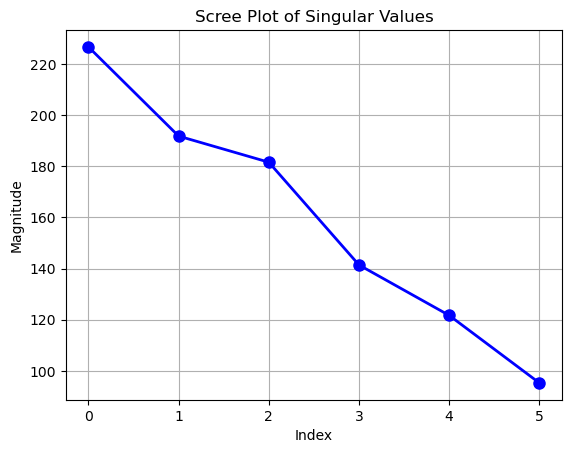

In [174]:
from run_crc import preprocess_crc
from scipy.sparse.linalg import svds

root_path = os.path.join(os.getcwd(), "data/stanford-crc")
dataset_root = os.path.join(root_path, "dataset")
model_root = os.path.join(root_path, "model")

filenames = sorted(set(f.split(".")[0] for f in os.listdir(dataset_root)))
filenames = [f for f in filenames if f]

data_inputs = []
for filename in filenames:
    paths = {kind: os.path.join(dataset_root, f"{filename}.{kind}.csv") for kind in ['D', 'edge', 'coord', 'type']}

    D = pd.read_csv(paths['D'], index_col=0, converters={0: tuple_converter})
    edge_df = pd.read_csv(paths['edge'], index_col=0)
    coord_df = pd.read_csv(paths['coord'], index_col=0)
    type_df = pd.read_csv(paths['type'], index_col=0)

    coords_df = pd.merge(coord_df, type_df).reset_index(drop=True)

    X, _, _, _, _, _ = preprocess_crc(coords_df, edge_df, D, phi=0.1)

    data_inputs.append(X.values)
    del D, X
    gc.collect()

X_full = np.vstack(data_inputs)
U, L, V = svds(X_full, k=7)
singular_values = sorted(L, reverse=True)

plt.plot(singular_values, 'o-', color='b', markersize=8, linewidth=2)
plt.title('Scree Plot of Singular Values')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

In [180]:
from numpy.linalg import svd
U_full, L_full, V_full = svd(X_full, full_matrices=False)

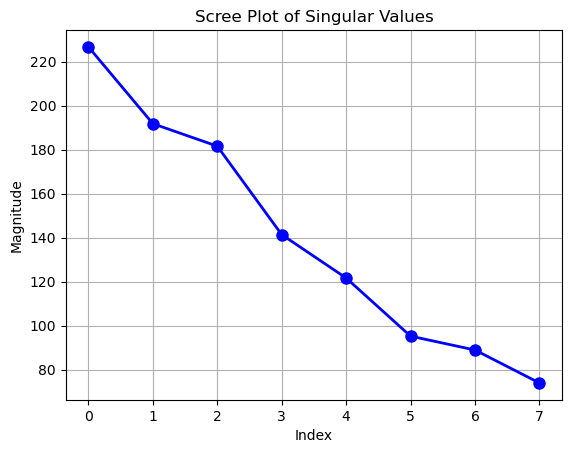

In [181]:
singular_values = sorted(L_full, reverse=True)

plt.plot(singular_values, 'o-', color='b', markersize=8, linewidth=2)
plt.title('Scree Plot of Singular Values')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

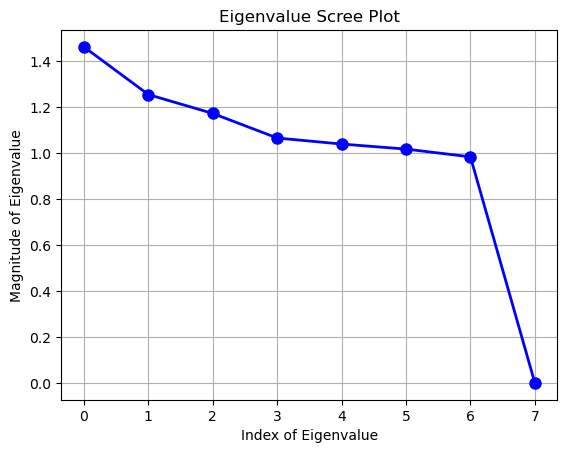

In [179]:
from sklearn.decomposition import PCA

X_normalized = (X_full - np.mean(X_full, axis=0)) / np.std(X_full, axis=0)

pca = PCA()
pca.fit(X_normalized)

eigenvalues = pca.explained_variance_

plt.plot(eigenvalues, 'o-', color='b', markersize=8, linewidth=2)
plt.title('Eigenvalue Scree Plot')
plt.xlabel('Index of Eigenvalue')
plt.ylabel('Magnitude of Eigenvalue')
plt.grid(True)
plt.show()

- if eigengaps are small the topics can actually switch around
- rotation on V to make it sparse and compare it with alternatinng methods

In [208]:
root_path = os.path.join(os.getcwd(), "data/stanford-crc")
model_root = os.path.join(root_path, "model")
save_path = os.path.join(model_root, 'SPLSI_complete_5_0426.npz')
data_splsi = np.load(save_path)
A_hat_splsi = data_splsi['A_hat']
W_splsi = data_splsi['W_hat']
time_splsi = data_splsi['time']

In [200]:
save_path = os.path.join(model_root, 'SPLSI_complete_6_no_align.npz')
data_splsi = np.load(save_path)
A_hat_splsi = data_splsi['A_hat']
W_splsi = data_splsi['W_hat']
time_splsi = data_splsi['time']

In [237]:
def _euclidean_proj_simplex(v, s=1):
        (n,) = v.shape
        # check if we are already on the simplex
        if v.sum() == s and np.alltrue(v >= 0):
            return v
        
        u = np.sort(v)[::-1]
        cssv = np.cumsum(u)
        rho = np.nonzero(u * np.arange(1, n + 1) > (cssv - s))[0][-1]
       
        theta = (cssv[rho] - s) / (rho + 1.0)
        w = (v - theta).clip(min=0)
        return w
        
def get_A_hat(W_hat, M):
        projector = (np.linalg.inv(W_hat.T.dot(W_hat))).dot(W_hat.T)
        theta = projector.dot(M)
        theta_simplex_proj = np.array([_euclidean_proj_simplex(x) for x in theta])
        return theta_simplex_proj

In [240]:
model_root = os.path.join(root_path, "model")
save_path = os.path.join(model_root, 'model_splsi_all_2.pkl')
with open(save_path, "rb") as f:
        model = pickle.load(f)
M = (model.U @ model.L) @ model.V.T
A_hat_splsi = get_A_hat(model.W_hat, M)


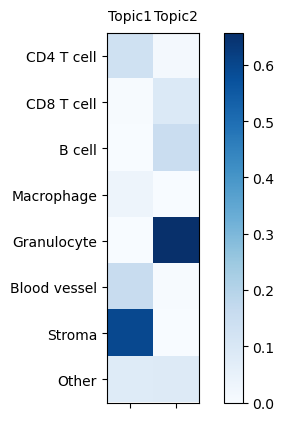

In [241]:
row_names = ["Topic"+str(i) for i in range(1,3)]
plt.imshow(A_hat_splsi.T, cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(len(row_names)), row_names)
plt.yticks(np.arange(len(column_names)), column_names)
plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.colorbar()
plt.show()

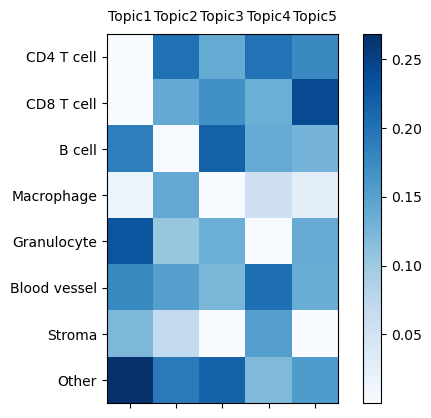

In [232]:
row_names = ["Topic"+str(i) for i in range(1,6)]
plt.imshow(A_hat_splsi.T, cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(len(row_names)), row_names)
plt.yticks(np.arange(len(column_names)), column_names)
plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.colorbar()
plt.show()

<AxesSubplot:>

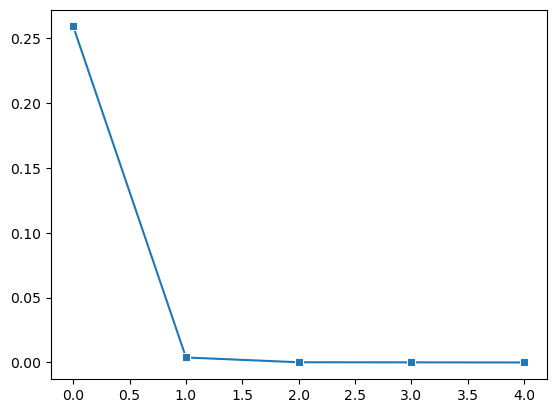

In [204]:
errors  =[0.25902392593846457, 0.0038671562122810643, 0.00017541572381486042,
          0.00010239358751809981, 1.0498243059759338e-05]
sns.lineplot(errors, marker='s')

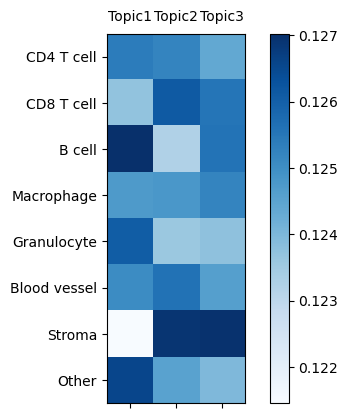

In [196]:
column_names = D.columns
row_names = ["Topic"+str(i) for i in range(1,4)]
plt.imshow(A_hat_splsi.T, cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(len(row_names)), row_names)
plt.yticks(np.arange(len(column_names)), column_names)
plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.colorbar()
plt.show()

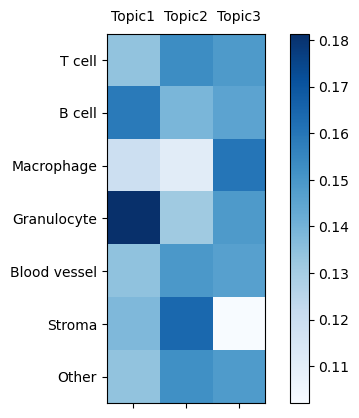

In [129]:
column_names = D.columns
row_names = ["Topic"+str(i) for i in range(1,4)]
plt.imshow(A_hat_splsi.T, cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(len(row_names)), row_names)
plt.yticks(np.arange(len(column_names)), column_names)
plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.colorbar()
plt.show()

In [122]:
A_hat_splsi

array([[0.14221507, 0.14654976, 0.14174533, 0.1417694 , 0.14231   ,
        0.14207838, 0.14333205],
       [0.14229849, 0.14221725, 0.14319217, 0.14640322, 0.14290005,
        0.14108542, 0.1419034 ],
       [0.14230463, 0.14171681, 0.14404331, 0.14117216, 0.14234015,
        0.14580673, 0.14261624]], dtype=float32)

In [73]:
import os
import sys
import numpy as np
from numpy.linalg import norm
import networkx as nx

from scipy.sparse.linalg import svds

from SpLSI.utils import *
from utils.data_helpers import *
from run_crc import *
from SpLSI.splsi import SpLSI

root_path = os.path.join(os.getcwd(), "data/stanford-crc")
dataset_root = os.path.join(root_path, "dataset_test")
model_root = os.path.join(root_path, "model_test")
fig_root = os.path.join(root_path, "fig_test")
os.makedirs(model_root, exist_ok=True)
os.makedirs(fig_root, exist_ok=True)

filenames = sorted(set(f.split(".")[0] for f in os.listdir(dataset_root)))
filenames = [f for f in filenames if f]

filename = filenames[0]
data_inputs = []
for filename in filenames:
    path_to_D = os.path.join(dataset_root, "%s.D.csv" % filename)
    path_to_edge = os.path.join(dataset_root, "%s.edge.csv" % filename)
    path_to_coord = os.path.join(dataset_root, "%s.coord.csv" % filename)
    path_to_type = os.path.join(dataset_root, "%s.type.csv" % filename)
    path_to_model = os.path.join(model_root, "%s.model.pkl" % filename)

    D = pd.read_csv(path_to_D, index_col=0, converters={0: tuple_converter})
    edge_df = pd.read_csv(path_to_edge, index_col=0)
    coord_df = pd.read_csv(path_to_coord, index_col=0)
    type_df = pd.read_csv(path_to_type, index_col=0)

    coords_df = pd.merge(coord_df, type_df).reset_index(drop=True)

    X, edge_df, _, weights, n, _ = preprocess_crc(coords_df, edge_df, D, phi=0.1)
    _, fold1, fold2, G, _ = get_folds_disconnected_G(edge_df)
    
    folds = {0: fold1, 1: fold2}
    data_inputs.append((X, G, weights, folds, n))

X = np.vstack([input[0].values for input in data_inputs])
U, _, V = svds(X, k=3)
V  = V.T
n_complete = sum([input[4] for input in data_inputs])

In [205]:
meta = pd.read_csv('/Users/jeong-yeojin/Desktop/SpLSI/data/stanford-crc/charville_labels.csv')
meta[pd.isna(meta['primary_outcome'])].index

Index([  4,  14,  15,  21,  24,  25,  26,  27,  38,  39,  40,  41,  42,  45,
        46,  47,  48,  49,  50,  51,  52,  54,  55,  61,  62,  63,  64,  65,
        72,  73,  74,  75,  76,  77,  78,  83,  84,  85,  86,  87,  88,  89,
        90,  92,  95,  97,  98,  99, 100, 101, 103, 105, 106, 107, 108, 109,
       111, 112, 113, 114, 115, 116, 117, 118, 120, 123, 124, 126, 127, 128,
       129, 131, 132, 140, 141, 149, 152, 158, 161, 167, 179, 196, 210, 217,
       242, 255, 257, 258, 259, 260, 262, 268, 273, 279, 287, 289],
      dtype='int64')

In [ ]:
# - initialization

In [206]:
meta

,region_id,primary_outcome,recurrence,alive_or_deceased,type_of_first_recurrence,surgery_date,first_recurrence_date,last_contact_date,length_of_disease_free_survival,grade_differentiation,acquisition_id_visualizer,sample_label_visualizer
0,Charville_c001_v001_r001_reg001,0.0,0.0,Alive,NONE/DISEASE FREE,3/9/2010,NONE,3/7/2012,24.0,2,SpaceGMP-65_c001_v001_r001_reg001,24219_040715
1,Charville_c001_v001_r001_reg002,1.0,1.0,Alive,"DIST RECUR, LIVER",2/25/2009,7/19/2010,2/21/2012,17.0,2,SpaceGMP-65_c001_v001_r001_reg002,24210_040714
2,Charville_c001_v001_r001_reg003,1.0,1.0,Alive,"DIST RECUR, LIVER",2/25/2009,7/19/2010,2/21/2012,17.0,2,SpaceGMP-65_c001_v001_r001_reg003,24210_040713
3,Charville_c001_v001_r001_reg004,1.0,1.0,Dead,"DIST RECUR, PERITONEUM",6/7/2006,3/21/2007,5/5/2008,9.0,2,SpaceGMP-65_c001_v001_r001_reg004,24227_040712
4,Charville_c001_v001_r001_reg007,NaN,NaN,Alive,NONE/DISEASE FREE,12/2/2010,NONE,1/30/2012,14.0,2,SpaceGMP-65_c001_v001_r001_reg007,24221_040811
...,...,...,...,...,...,...,...,...,...,...,...,...
287,Charville_c004_v001_r001_reg175,NaN,NaN,Alive,NEVER DISEASE FREE,1/14/2009,NONE,7/5/2011,NaN,2,SpaceGMP-65_c004_v001_r001_reg175,21915_010207
288,Charville_c004_v001_r001_reg176,0.0,0.0,Alive,NONE/DISEASE FREE,2/26/2009,NONE,8/17/2011,30.0,3,SpaceGMP-65_c004_v001_r001_reg176,21947_010307
289,Charville_c004_v001_r001_reg177,NaN,NaN,Alive,NONE/DISEASE FREE,4/8/2009,NONE,3/15/2010,11.0,2,SpaceGMP-65_c004_v001_r001_reg177,21956_010407
290,Charville_c004_v001_r001_reg178,0.0,0.0,Alive,NONE/DISEASE FREE,2/14/2006,NONE,11/1/2010,57.0,2,SpaceGMP-65_c004_v001_r001_reg178,22108_010507


In [ ]:
data_path = '/Users/jeong-yeojin/Desktop/SpLSI/data/stanford-crc/model_test'
filenames = sorted(set(f.split('.')[0] for f in os.listdir(data_path)))
if "" in filenames:
        filenames.remove("")
os.makedirs(os.path.join(data_path,'Ahats'), exist_ok=True)
os.makedirs(os.path.join(data_path,'Whats'), exist_ok=True)

topics = [i+1 for i in range(6)]
results = defaultdict(list)
for filename in filenames:
    path_to_model = os.path.join(data_path,f'{filename}.model.pkl')
    with open(path_to_model, "rb") as f:
        model = pickle.load(f)
        for topic in topics:
            chaos = model[topic][0]['chaoss']
            pas = model[topic][0]['pas']
            morans = model[topic][0]['morans']
            times = model[topic][0]['times']
            results['ID'].append(filename)
            results['K'].append(topic)
            results['splsi_chaos'].append(chaos[0])
            results['splsi_pas'].append(pas[0])
            results['splsi_morans'].append(morans[0])
            results['splsi_time'].append(times[0])
            results['plsi_chaos'].append(chaos[1])
            results['plsi_pas'].append(pas[1])
            results['plsi_morans'].append(morans[1])
            results['plsi_time'].append(times[1])
            results['slda_chaos'].append(chaos[2])
            results['slda_pas'].append(pas[2])
            results['slda_morans'].append(morans[2])
            results['slda_time'].append(times[2])
results = pd.DataFrame(results)   

In [19]:
data_path = '/Users/jeong-yeojin/Desktop/SpLSI/data/stanford-crc/model_test'
filenames = sorted(set(f.split('.')[0] for f in os.listdir(data_path)))
if "" in filenames:
        filenames.remove("")
vars = ['Ahats', 'Whats']

topics = [i+1 for i in range(6)]
methods = ['SPLSI','PLSI','SLDA']

for var in vars:
    os.makedirs(os.path.join(data_path,var), exist_ok=True)

for filename in filenames:
    path_to_model = os.path.join(data_path,f'{filename}.model.pkl')
    with open(path_to_model, "rb") as f:
        model = pickle.load(f)
    for topic in topics:
        for var in vars:
            for i, method in enumerate(methods):
                save_path = os.path.join(data_path,var,f'{filename}_{var}_{topic}_{method}.csv')
                est = pd.DataFrame(model[topic][0][var][i])
                est.to_csv(save_path)


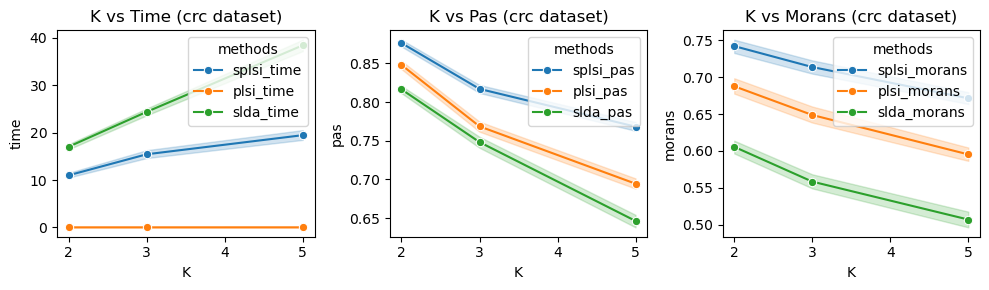

In [34]:
variables = ['time', 'pas', 'morans']

fig, axes = plt.subplots(1, 3, figsize=(10,3))
axes = axes.flatten()

for idx, variable in enumerate(variables):
    df_melted = pd.melt(
        results,
        id_vars="K",
        var_name="methods",
        value_vars=[f"splsi_{variable}", f"plsi_{variable}", f"slda_{variable}"],
        value_name=variable,
    )
    sns.lineplot(x="K", y=variable, hue="methods", data=df_melted, marker="o", ax=axes[idx]).set(title=f"K vs {variable.capitalize()} (crc dataset)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [36]:
results.to_csv('results_crc.csv')

In [186]:
data_path = "data/stanford-crc/dataset2"
filenames = sorted(set(f.split('.')[0] for f in os.listdir(data_path)))
if "" in filenames:
    filenames.remove("")
filename = filenames[1]

path_to_D = os.path.join(data_path, "%s.D.csv" % filename)
D = pd.read_csv(path_to_D, index_col=0, converters={0: tuple_converter})
path_to_edge = os.path.join(data_path, "%s.edge.csv" % filename)
edge_df = pd.read_csv(path_to_edge, index_col=0)
path_to_coord = os.path.join(data_path, "%s.coord.csv" % filename)
coord_df = pd.read_csv(path_to_coord,  index_col=0)
path_to_type = os.path.join(data_path, "%s.type.csv" % filename)
type_df = pd.read_csv(path_to_type,  index_col=0)

coords_df = pd.merge(coord_df, type_df).reset_index(drop=True)


In [45]:
filename = filenames[10]
path_to_D = os.path.join(data_path, "%s.D.csv" % filename)
D2 = pd.read_csv(path_to_D, index_col=0, converters={0: tuple_converter})
path_to_coord = os.path.join(data_path, "%s.coord.csv" % filename)
coord_df2 = pd.read_csv(path_to_coord,  index_col=0)
path_to_type = os.path.join(data_path, "%s.type.csv" % filename)
type_df2 = pd.read_csv(path_to_type,  index_col=0)

coords_df2 = pd.merge(coord_df, type_df).reset_index(drop=True)

In [68]:
new_columns = [col.replace("X", "x").replace("Y", "y") for col in coords_df.columns]
coords_df.columns = new_columns
coords_df[["x", "y"]] = normaliza_coords(coords_df)

cell_to_idx_dict = dict(zip(coords_df["CELL_ID"], range(coords_df.shape[0])))

edge_df_ = edge_df.copy()
edge_df_["src"] = edge_df["src"].map(cell_to_idx_dict)
edge_df_["tgt"] = edge_df["tgt"].map(cell_to_idx_dict)
edge_df_["weight"] = dist_to_exp_weight(edge_df_, coords_df, 0.1)

In [3]:
ntopics_list = [3]
spatial_models = {}
for ntopic in ntopics_list:
    res = run_crc(coord_df = coords_df, 
                  edge_df = edge_df, 
                  D = D, 
                  K = ntopic,
                  phi = 0.1)
    spatial_models[ntopic] = res

Running spatial SVD...


/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/src/pycvxcluster/algos/ssnal.py:341: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/src/pycvxcluster/algos/ssnal.py:341: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor =

Error is 0.02376886880642412


/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/src/pycvxcluster/algos/ssnal.py:341: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/src/pycvxcluster/algos/ssnal.py:341: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Error is 1.4363218141389066e-05
SpatialSVD ran for 2 steps.
Running SPOC...
Running vanilla SVD...
Running SPOC...
Running SLDA...
0
0
0


In [4]:
A_hat_splsi_1 = spatial_models[3][0]['model_splsi'].A_hat.T
A_hat_plsi_1 = spatial_models[3][0]['model_plsi'].A_hat.T
Aslda = spatial_models[3][0]['model_slda'].components_
row_sums = Aslda.sum(axis=1, keepdims=True)
A_hat_slda_1 = (Aslda / row_sums).T

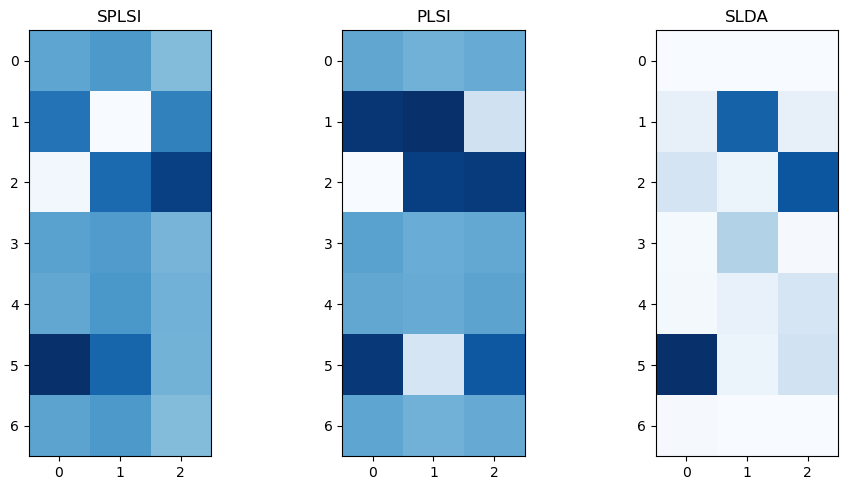

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(A_hat_splsi_1, cmap='Blues', interpolation='nearest')
axs[0].set_title('SPLSI')

axs[1].imshow(A_hat_plsi_1, cmap='Blues', interpolation='nearest')
axs[1].set_title('PLSI')

axs[2].imshow(A_hat_slda_1, cmap='Blues', interpolation='nearest')
axs[2].set_title('SLDA')

plt.tight_layout()
plt.show()

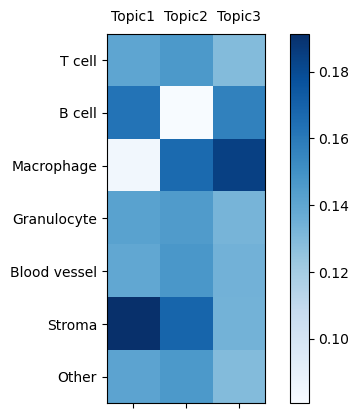

In [15]:
column_names = D.columns
row_names = ["Topic"+str(i) for i in range(1,4)]
plt.imshow(A_hat_splsi_1, cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(len(row_names)), row_names)
plt.yticks(np.arange(len(column_names)), column_names)
plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.colorbar()
plt.show()

In [ ]:
# 매크로가 여러개가 합쳐진 / 선천적으로 면역을 담당하는 중요한 macrophage (강성훈, 전혜린)

In [7]:

def plot_spleen_topic(spatial_models, ntopics_list, s):
    aligned_models = apply_order(spatial_models, ntopics_list)
    color_palette = sns.color_palette("husl", 10)
    colors = np.array(color_palette[:10])

    names = ['SPLSI','PLSI','SLDA']
    for ntopic in ntopics_list:
        chaoss = spatial_models[ntopic][0]['chaoss']
        morans = spatial_models[ntopic][0]['morans']
        pas = spatial_models[ntopic][0]['pas']
        times = spatial_models[ntopic][0]['times']
        fig, axes = plt.subplots(1,3, figsize=(18,6))
        for j, ax in enumerate(axes):
            w = np.argmax(aligned_models[ntopic][0]['Whats'][j], axis=1)
            samp_coord_ = aligned_models[ntopic][0]['coord_df'].copy()
            samp_coord_['tpc'] = w
            ax.scatter(samp_coord_['x'], samp_coord_['y'], s=s, c=colors[w])
            name = names[j]
            ax.set_title(f'{name} (chaos:{np.round(chaoss[j],7)}, moran:{np.round(morans[j],2)}, pas:{np.round(pas[j],2)}, time:{np.round(times[j],2)})')
        plt.tight_layout()
        plt.show()
    return aligned_models

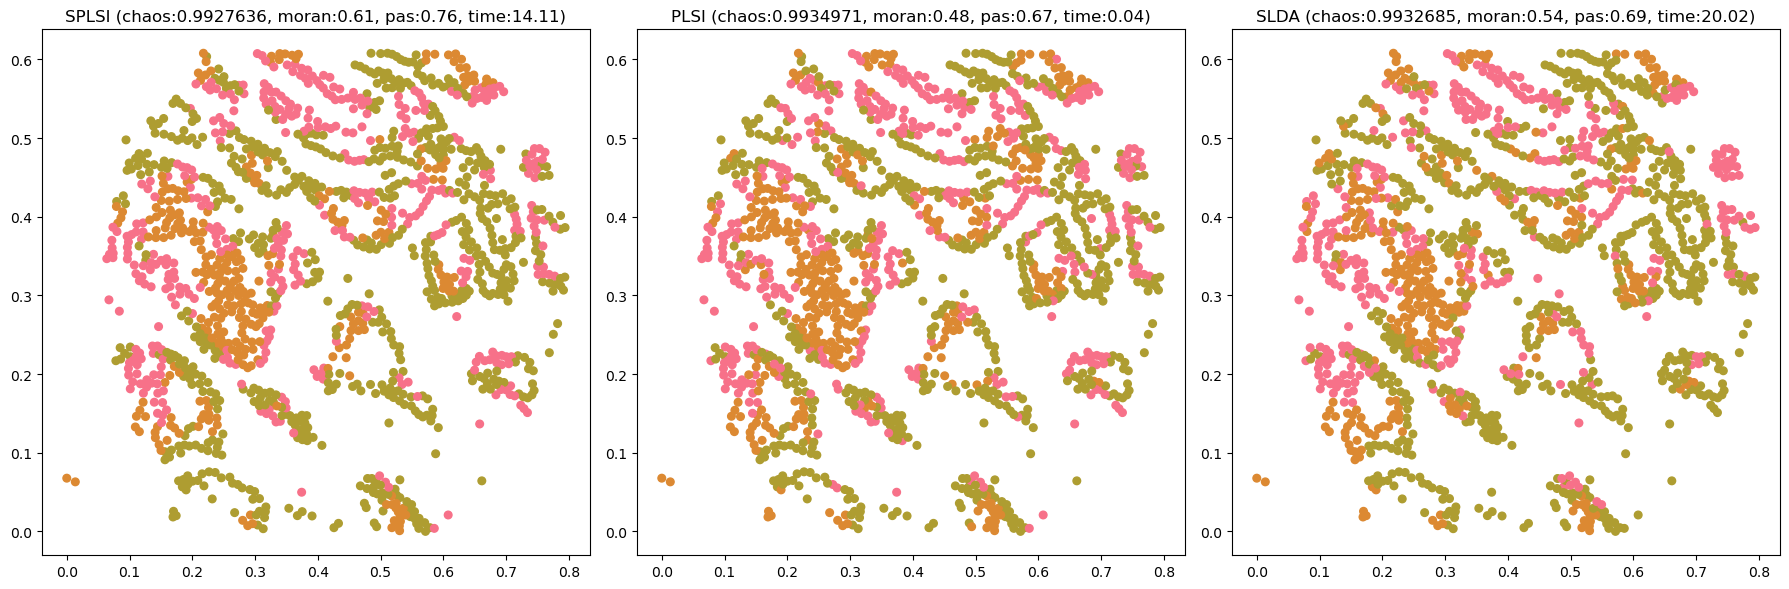

In [10]:
aligned_models = plot_spleen_topic(spatial_models, ntopics_list, 30)

In [49]:
data_path = '/Users/jeong-yeojin/Desktop/SpLSI/data/stanford-crc/model/Charville_c002_v001_r001_reg115.model.pkl'
#What = pd.read_csv(data_path)
with open(data_path, "rb") as f:
        model = pickle.load(f)


In [17]:
coords_df = pd.read_csv('/Users/jeong-yeojin/Desktop/SpLSI/data/stanford-crc/dataset_test/Charville_c001_v001_r001_reg001.coord.csv')

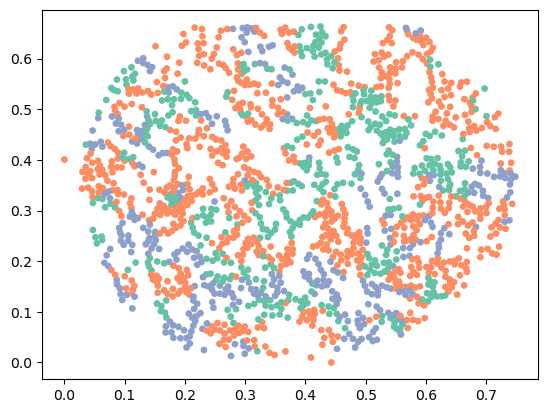

In [54]:
color_palette = sns.color_palette("Set2", 10)
colors = np.array(color_palette[:10])
ntopic=3
w = np.argmax(model[ntopic][0]['Whats'][0], axis=1)
#w = np.argmax(model.W_hat[:1396], axis=1)
samp_coord_ = model[ntopic][0]['coord_df'].copy()
samp_coord_['tpc'] = w
plt.scatter(samp_coord_['x'], samp_coord_['y'], s=15, c=colors[w])